In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import pickle
import math
import optuna
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn import preprocessing
from NFLUtils import NFLUtils
nfl_utils = NFLUtils()

%matplotlib inline

# ANN
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

import logging
# Set up logging
logging.basicConfig(level=logging.INFO)
# Set pandas display option to show all columns
pd.set_option('display.max_columns', None)

# XGBoost 
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns # confusion matrix

# Set device to GPU if available 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def set_all_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Load CSV & UMAP model
cp Combined.csv ~/drive/Notes/ML/Pytorch/footballData/

In [3]:
# Load CSV
df = pd.read_csv("./footballData/CombinedSlidingWindow4.csv", index_col=False, low_memory=False)

df.info()

# The performance set's size is defined in the SlidingWindowNFL-1 file. When kick_punt_umap_dim_1 (or 2) is blank
test_performance_df = df[df['kick_punt_umap_dim_1'].isna()]
df = df[df['kick_punt_umap_dim_1'].isna() == False]
print(f'df after perf set removed: {df.shape}')
print(f'performance set size: {test_performance_df.shape}')

# Remove missing odds data (Ignore data with no odds?)
test_performance_df = test_performance_df[test_performance_df['D_start_odds'] != 0.0]

print(f'df after missing odds removed: {df.shape}')
print(f'df perf after missing odds removed: {test_performance_df.shape}')

# Load the UMAP
filename = "kick_punt_umap.sav"
umap_model = None
try:
    with open(filename, 'rb') as file:
        umap_model = pickle.load(file)
        print(type(umap_model))
except EOFError:
    print("The file is empty or corrupt. Please check its content.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5464 entries, 0 to 5463
Data columns (total 62 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               5464 non-null   int64  
 1   Season                   5464 non-null   int64  
 2   Date                     5464 non-null   object 
 3   Home_Team                5464 non-null   object 
 4   Visitor_Team             5464 non-null   object 
 5   H_halftime_odds          5464 non-null   float64
 6   V_halftime_odds          5464 non-null   float64
 7   H_start_odds             5464 non-null   float64
 8   V_start_odds             5464 non-null   float64
 9   H_Won                    5464 non-null   float64
 10  D_First_Downs            5464 non-null   float64
 11  D_Rush                   5464 non-null   float64
 12  D_Yds                    5464 non-null   float64
 13  D_TDs                    5464 non-null   float64
 14  D_Att                   

### Remove items w/ missing odds data, apply UMAP to performance set

In [4]:
# Remove missing odds data
test_performance_df = test_performance_df[test_performance_df['D_start_odds'] != 0.0]
print(test_performance_df.shape)

# ---- Apply UMAP to performance set ----
# Fit standardScaler on the training set
umap_columns = ["D_kick_punt_returns_lng", "D_kick_punt_returns_rt", "D_kick_punt_returns_yds"]
umap_train_df = df[umap_columns]
umap_scaler = StandardScaler().fit(umap_train_df)

# Scale the test set
scaled_return_game_df = umap_scaler.transform(test_performance_df[umap_columns])

if umap_model is None:
    print("UMAP not correctly loaded FIX NOW")

umap_embedding = umap_model.transform(scaled_return_game_df)
print(umap_embedding.shape)

# Create the two new columns, drop the 4
test_performance_df['kick_punt_umap_dim_1'] = umap_embedding[:,0]
test_performance_df['kick_punt_umap_dim_2'] = umap_embedding[:,1]

test_performance_df.drop(umap_columns, axis=1, inplace=True)
df.drop(umap_columns, axis=1, inplace=True)



(191, 62)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(191, 2)


In [5]:
test_performance_df[:5]
# print(test_performance_df['H_start_odds'][:5])
# print(test_performance_df['V_start_odds'][:5])

,Unnamed: 0,Season,Date,Home_Team,Visitor_Team,H_halftime_odds,V_halftime_odds,H_start_odds,V_start_odds,H_Won,D_First_Downs,D_Rush,D_Yds,D_TDs,D_Att,D_Sacked,D_Sacked_Yards,D_Total_Yards,D_Fumbles,D_Turnovers,D_Penalties,D_Fourth_Down_Conv,D_Time_of_Possession,D_passing_att,D_passing_cmp,D_passing_int,D_passing_lng,D_passing_sk,D_passing_td,D_receiving_lng,D_rushing_att,D_rushing_lng,D_rushing_td,D_rushing_yds,D_passing_rushing_td,D_def_interceptions_int,D_def_interceptions_td,D_def_interceptions_yds,D_fumbles_ff,D_fumbles_fr,D_fumbles_td,D_fumbles_yds,D_sk,D_tackles_ast,D_tackles_comb,D_punting_pnt,D_punting_avg,D_scoring_fga,D_scoring_fgp,D_scoring_xpa,D_scoring_xpp,D_Final,D_Final_Allowed,D_start_odds,D_halftime_odds,D_datediff,D_pythagorean,kick_punt_umap_dim_1,kick_punt_umap_dim_2
5264,7449,2023,2024-01-21,KAN,BUF,2.386667,1.577778,2.073398,1.724771,1.0,-5.233,17.242,-2.987,-15.709,-96.021,4.730,1.023,-61.716,-0.632,-0.631,0.755,32.122,-5.573,3.233,0.864,-0.456,-1.058,0.125,-0.128,7.821,-11.879,-4.020,-0.786,-32.182,-0.914,-1.455,-0.240,-9.988,0.526,-0.169,0.277,25.995,1.133,-2.529,8.645,0.721,2.949,1.506,0.228,-1.316,-0.013,-5.027,-0.352,0.349,0.809,2.0,-0.073,-1.816091,9.709170
5265,7444,2023,2024-01-28,DET,SFO,1.263333,3.894444,4.307745,1.203585,0.0,-0.372,-13.742,-0.238,-10.965,8.056,4.363,-1.095,3.401,0.212,-0.425,18.047,29.457,-1.453,3.159,3.515,-0.292,-3.346,-0.426,-0.040,7.841,-1.729,-18.916,0.261,-30.240,0.221,-0.158,-0.085,3.741,0.676,-0.213,0.000,2.740,0.631,-2.386,-1.306,1.009,1.431,-0.111,0.265,-0.153,-0.014,1.441,2.452,3.104,-2.631,-1.0,-0.178,5.034655,6.042508
5266,7445,2023,2024-01-28,KAN,BAL,1.345556,3.222222,2.885004,1.396731,1.0,0.069,-44.346,-3.191,11.977,21.311,-0.159,-9.885,1.517,-0.661,0.089,2.567,-21.801,1.449,8.621,4.783,0.487,-3.435,-1.162,-1.387,-15.969,-2.393,-16.718,-0.296,-22.318,-1.683,-0.806,-0.011,-13.917,-1.068,-0.167,0.207,15.009,0.170,-10.952,-11.826,-0.849,1.145,1.322,0.107,-1.480,-0.013,-7.266,-2.992,1.488,-1.877,-1.0,-0.126,1.017909,10.463038
5267,7645,2023,2024-02-11,SFO,KAN,1.301111,3.472222,1.757009,2.028809,0.0,1.647,32.044,4.502,-57.237,-36.737,-1.440,7.760,28.547,-0.720,-0.144,-5.344,-20.965,3.099,1.080,0.941,0.384,8.206,1.219,0.349,8.171,0.820,-5.505,0.875,2.493,1.224,1.109,0.080,14.806,-0.568,-0.790,-0.146,-13.610,0.056,-4.949,-8.703,0.505,-1.003,-1.408,-0.375,1.169,-0.061,2.762,3.159,-0.272,-2.171,0.0,0.104,6.973550,5.255773
5268,7808,2024,2024-10-10,SFO,SEA,1.056667,9.383333,1.461897,2.642566,1.0,-4.958,6.489,4.651,-22.117,-71.139,-0.714,-4.221,8.161,1.450,-0.186,-24.648,5.888,1.479,-12.781,-10.602,-0.471,-1.445,-0.758,0.452,4.037,9.005,-3.662,-1.432,25.173,-0.980,0.292,0.460,23.952,1.212,1.978,0.000,-0.919,0.842,-0.910,-4.699,-1.600,-0.863,0.947,0.382,0.095,0.000,0.105,-5.610,-1.181,-8.327,0.0,0.026,-2.135451,8.175879


# Columns to use
(TODO)

## 1. Separate continuous, categorical, and label column names

Pretty much everything is continuous. 

Note: the y_col is what you're trying to predict

## Feature engineering
New Columns
- **h_win**: Home team won


In [6]:
cat_cols = []

cont_cols = [col for col in nfl_utils.cont_cols if col not in nfl_utils.drop_cols]


y_col = ['H_Won'] # Old
y_col = ['H_Won', 'H_start_odds', 'V_start_odds']
y_col_perf = ['H_Won', 'H_start_odds', 'V_start_odds', 'H_halftime_odds', 'V_halftime_odds']


# create cont_df and y_df from the df
print(df.shape)
cont_df = df[cont_cols]
y_df = df[y_col]

# test performance set
perf_conts_df = test_performance_df[cont_cols]
perf_y_df = test_performance_df[y_col_perf]
perf_date_df = test_performance_df[['Date','Home_Team', 'Visitor_Team']]

# print(cont_df.dtypes)
print(cont_df.shape)
print(perf_y_df.shape)
print(perf_y_df.tail())
# print(perf_conts_df.tail())


(5264, 59)
(5264, 44)
(191, 5)
      H_Won  H_start_odds  V_start_odds  H_halftime_odds  V_halftime_odds
5459    0.0      1.724771      2.073398              0.0              0.0
5460    0.0      4.991514      1.159063              0.0              0.0
5461    1.0      4.513858      1.188369              0.0              0.0
5462    0.0      3.804017      1.250000              0.0              0.0
5463    0.0      1.790476      1.986097              0.0              0.0


In [7]:
print(perf_y_df[:5])
cont_df[:5]

      H_Won  H_start_odds  V_start_odds  H_halftime_odds  V_halftime_odds
5264    1.0      2.073398      1.724771         2.386667         1.577778
5265    0.0      4.307745      1.203585         1.263333         3.894444
5266    1.0      2.885004      1.396731         1.345556         3.222222
5267    0.0      1.757009      2.028809         1.301111         3.472222
5268    1.0      1.461897      2.642566         1.056667         9.383333


,D_First_Downs,D_Rush,D_Yds,D_TDs,D_Att,D_Sacked,D_Sacked_Yards,D_Total_Yards,D_Fumbles,D_Turnovers,D_Penalties,D_Fourth_Down_Conv,D_Time_of_Possession,D_passing_att,D_passing_cmp,D_passing_int,D_passing_lng,D_passing_sk,D_passing_td,D_receiving_lng,D_rushing_att,D_rushing_lng,D_rushing_td,D_rushing_yds,D_def_interceptions_int,D_def_interceptions_td,D_def_interceptions_yds,D_fumbles_ff,D_fumbles_fr,D_fumbles_td,D_fumbles_yds,D_sk,D_tackles_ast,D_tackles_comb,kick_punt_umap_dim_1,kick_punt_umap_dim_2,D_punting_pnt,D_punting_avg,D_scoring_fga,D_scoring_fgp,D_scoring_xpa,D_scoring_xpp,D_pythagorean,D_start_odds
0,2.458,12.544,-5.783,19.893,23.800,0.823,-3.716,130.102,-0.168,-1.247,24.166,35.846,-1.623,16.687,8.510,-1.188,30.763,-1.752,1.528,31.876,-6.806,24.304,-0.135,-9.370,0.123,0.276,9.709,0.0,-0.739,0.000,-5.688,0.142,0.0,0.0,6.173783,9.196926,0.463,-0.274,0.755,-0.058,1.813,0.384,0.114,1.181
1,-2.785,-50.035,-19.715,112.129,146.006,-5.386,-1.774,-38.771,0.222,0.963,-5.829,15.574,-4.341,-2.395,0.881,1.251,21.204,1.686,0.916,11.753,-12.632,-16.871,-1.835,-70.724,-0.679,0.000,2.274,0.0,1.242,-0.144,-10.722,-0.989,0.0,0.0,10.883607,12.892086,-0.914,5.188,1.672,-0.036,-1.504,0.180,-0.063,1.330
2,2.375,-10.388,-6.223,48.076,75.847,-4.661,-6.933,66.426,-0.755,-1.166,-17.059,15.574,-2.231,0.097,-0.543,-0.400,5.771,-2.320,0.162,24.184,-2.963,9.643,-0.313,-2.937,-0.907,-0.144,-8.833,0.0,-0.042,-0.400,-18.496,-0.106,0.0,0.0,2.963156,2.741191,-1.234,-3.694,0.865,0.166,-0.695,-0.409,0.179,0.741
3,7.449,-12.747,0.834,-15.864,45.930,-1.158,-14.354,154.068,0.556,3.718,-14.652,51.436,5.712,14.515,11.494,3.382,22.413,-3.191,-0.283,53.642,0.534,-7.527,1.139,-10.679,0.709,0.165,9.294,0.0,0.783,0.000,0.662,0.915,0.0,0.0,7.347951,9.682181,-4.908,-3.930,2.026,0.253,-0.192,-0.244,0.248,-5.646
4,3.060,-10.761,11.879,-13.824,-99.121,-2.287,1.223,0.313,0.597,0.036,16.379,11.556,1.515,-6.552,-7.106,-0.220,-6.811,0.196,-1.366,-39.378,8.608,-6.437,0.775,35.113,-0.089,-0.240,-19.492,0.0,-0.986,0.276,2.467,-0.431,0.0,0.0,2.351245,3.517297,-1.102,-4.524,-0.890,0.055,-0.256,0.000,0.007,1.181


#### 1a. Normalize cont_df
StandardScaler is instead used by the pipeline

In [8]:
# min_max_scaler = preprocessing.MinMaxScaler()
# cont_scaled = min_max_scaler.fit_transform(cont_df.values)
# cont_df = pd.DataFrame(cont_scaled)
# cont_df.head()

# # test performance set
# perf_conts_df_scaled = min_max_scaler.fit_transform(perf_conts_df.values)
# perf_conts_df = pd.DataFrame(perf_conts_df_scaled)

### 3. Create an array of continuous values
Numpy array 'conts' containing stack of each continuous column

In [9]:
conts = np.stack([cont_df[col].values for col in list(cont_df.columns)], 1)
conts[:5]

y_col = np.stack([y_df[col].values for col in y_col], 1)

# test performance set
perf_conts = np.stack([perf_conts_df[col].values for col in list(perf_conts_df.columns)], 1)
perf_y_col = np.stack([perf_y_df[col].values for col in list(perf_y_df.columns)], 1)
perf_date_col = np.stack([perf_date_df[col].values for col in list(perf_date_df.columns)], 1)


conts_train = conts
y_train = y_col

### 4. Convert conts to tensor

In [10]:
print(conts.shape)
print(y_col.shape)

(5264, 44)
(5264, 3)


In [11]:
# Handled by model.fit()
# conts = torch.tensor(conts, dtype=torch.float32)
# y_col = torch.tensor(y_col, dtype=torch.float32)

In [12]:
"""
Want: 
    An array > 1 elements for PCC formula
    A smaller array for kelly_criterion
    


x: 1d array of predictions between -1 and 1 where negative number means visitor predicted to win
y: ['H_Won', 'H_start_odds', 'V_start_odds']
pearson_multiplier: constant to multiply the pearson correlation coefficient's result by
max_bet_size: Amount to multiply to kelly criterion
"""
def nfl_custom_criterion(x, y, pearson_multiplier=0.5, max_bet_size=100):
    # ------------------------------------------------
    # Preliminary calculations
    # ------------------------------------------------
    h_start_odds = y[:,1]
    v_start_odds = y[:,2]
    h_won = y[:,0]
    y_decimal_odds = torch.where(x > 0, h_start_odds, v_start_odds) # Predicted vs actual odds (regardless of correct prediction)
    y_prob = 1 / y_decimal_odds                  # Probability (regardless of correct prediction)
    x_H_Won = torch.round(torch.sigmoid(20 * x)) # Sigmoid so that it's differentiable. The 20 is arbitrarily large number
    y_correct_prediction = torch.abs((x_H_Won - h_won))        # 1 if wrong bet, otherwise 0. Used to reset kelly when wrong
    y_correct_prediction_mult_two = 2 * y_correct_prediction   # 2 if wrong bet, 0 if correct
    x = torch.abs(x)

    
    # ------------------------------------------------
    # 1. Calculate the Pearson Correlation Coefficient
    # ------------------------------------------------
    n = x.size(0)
    sum_x = torch.sum(x)
    sum_x_squared = torch.sum(x**2)
    sum_y = torch.sum(y_prob)
    sum_y_squared = torch.sum(y_prob**2)
    sum_pow_x = torch.sum(x**2)
    sum_pow_y = torch.sum(y_prob**2)
    x_mul_y = torch.mul(x, y_prob)
    sum_x_mul_y = torch.sum(x_mul_y)

    
    # PCC Formula (eps to avoid NaN)
    eps = 1e-8
    pcc_numerator = n * sum_x_mul_y - sum_x * sum_y
    pcc_denominator_one = torch.sqrt(n * sum_pow_x - sum_x_squared + eps)
    pcc_denominator_two = torch.sqrt(n * sum_pow_y - sum_y_squared + eps)
    pcc = pcc_numerator / (pcc_denominator_one * pcc_denominator_two + eps)
    pcc = pearson_multiplier * torch.abs(pcc)

    
    # ------------------------------------------------
    # 2. Calculate the kelly criterion
    #    Entirely wrong predictions are negated and kept in "incorrect_bets" (pcc not applied to wrong predictions)
    #    Correct predictions are kept in "correct_bets". Pcc is applied to this & stored in pcc_adjusted_correct_bets
    #    Possible issue: This always bets max_bet_size
    #    The result is cumulatively calculated. i.e. The sum of the previous values are used to calculate the next one
    # ------------------------------------------------
    kelly_criterion = x - ((1 - x) / y_decimal_odds)
    bet_multiplier = torch.clamp(kelly_criterion, min=0)   # Kelly results that are negative are ignored
    bet_unadjusted_profit = bet_multiplier*max_bet_size    # Assumes all bets were correct

    correct_bets = bet_unadjusted_profit - (bet_unadjusted_profit * y_correct_prediction)   # All correct bets after kelly, profit or 0.
    pcc_adjusted_correct_bets = correct_bets * (1 - pcc)                                    # "correct_bets" penalized by pcc
    incorrect_bets = bet_unadjusted_profit - (bet_unadjusted_profit * y_correct_prediction_mult_two) # Negative numbers are incorrect bets
    incorrect_bets = torch.clamp(incorrect_bets, max=0)  # Restrict to 0 or negative.
    combined_bets = correct_bets + incorrect_bets        # Profit


    # ------------------------------------------------
    # Combine & Return
    #     Negate everything for Adam & optuna
    # ------------------------------------------------
    return -torch.cumsum(combined_bets, dim=0)[-1]

In [13]:
class TabularModelUpdated(nn.Module, BaseEstimator, ClassifierMixin):
    def __init__(self, n_cont, out_sz, layer_shape, p=0.5, # criterion=nn.MSELoss(),
                optimizer_class=torch.optim.Adam, lr=0.001, confidence_threshold=0.1,
                batch_size=1000):
        super().__init__()
        # Model architecture params
        self.layer_shape = layer_shape
        self.batch_size = batch_size
        self.n_cont = n_cont
        self.out_sz = out_sz
        self.p = p
        self.lr = lr
        
        # Training params
        # self.criterion = criterion
        self.confidence_threshold = confidence_threshold
        
        # BatchNorm layer for continuous data
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Variable that holds the list of layers
        layerlist = []
        n_in = n_cont # no embed again
        # Iterate through the passed in "layers" parameter (ie, [200,100]) to build a list of layers
        for i, width in enumerate(self.layer_shape):
            # First layer gets special treatment
            if i == 0:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.Mish(),  # Mish instead of ReLU
                    nn.BatchNorm1d(width),
                    nn.Dropout(p/2)  # Less dropout in earlier layers
                ])
            else:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.Mish(),
                    nn.BatchNorm1d(width),
                    nn.Dropout(p)
                ])
            n_in = width
        # layerlist.append(nn.Linear(layers[-1], out_sz))
        
        # Final layer
        layerlist.extend([
            nn.Linear(self.layer_shape[-1], out_sz),
            # nn.Softmax()  # Ensures output between 0 and 1
        ])
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
        # Initialize the optimizer
        self.optimizer = optimizer_class(self.parameters(), lr=self.lr)

        
    def forward(self, x_cont):
        x_cont = self.bn_cont(x_cont)  # Normalize the incoming continuous data
        x = self.layers(x_cont)        # Set up model layers
        return torch.clamp(x, -1, 1)
    
    def fit(self, X, y):
        """
        For sklearn pipeline
        """
        # Convert X,y to torch.tensor if needed
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        if not isinstance(y, torch.Tensor):
            y = torch.FloatTensor(y)
        
        # Initialize optimizer
        # optimizer = self.optimizer_class(self.parameters(), lr=self.lr)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        
        # Training loop
        self.train()
        for X_batch, y_batch in dataloader:
            self.optimizer.zero_grad()
            y_pred = self.forward(X_batch)[:,0]
            y_pred.requires_grad_()
            y_batch.requires_grad_()
            #loss = self.criterion(y_pred, y_batch)
            # loss = test_custom_loss(y_pred, y_batch)
            loss = nfl_custom_criterion(y_pred, y_batch)
            #print(loss)
            loss.backward()
            self.optimizer.step()
        return self
    
    def predict(self, X):
        probas = self.predict_proba(X)
        return probas
        # print("predict")
        # return (probas > 0.5).astype(int)
        # return probas
    
    def predict_proba(self, X):
        self.eval()
        with torch.no_grad():
            if not isinstance(X, torch.Tensor):
                X = torch.FloatTensor(X)
            return self(X)
        
    def score(self, X, y):
        """
        12/5 - this isn't called at all if 'scoring' is defined
        """
        probas = self.predict_proba(X)[:, 0]
        result = nfl_custom_criterion(probas, y)
        return result.item()

In [14]:
def objective(trial):
    # --- Suggest hyperparameters ---

    # criterion = trial.suggest_categorical('criterion', nfl_utils.map_losses(None).keys())
    batch_size = trial.suggest_categorical('batch_size', [100, 400, 1000, 3000])
    first_layer_size = trial.suggest_categorical('first_layer_size', [64, 56, 48, 32, 16, 12])
    min_layers = math.floor(math.sqrt(first_layer_size))
    num_layers = trial.suggest_int('num_layers', 2, min_layers)
    confidence_threshold = trial.suggest_float('confidence_threshold', 0, 0.05)
    layer_shape = [first_layer_size]
    for i in range(1, num_layers):
        layer_shape.append(first_layer_size//(2*i))
    
    # Set random state to have consistent results (42 is arbitrary)
    set_all_seeds()
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=False)

    # Split once
    X_train_fold = []
    X_val = []
    y_train_fold = []
    y_val = []
    models = []
    for train_index, val_index in kf.split(conts_train):
        # print(f"train {train_index.shape} val {val_index.shape}")
        X_train_fold.append(torch.FloatTensor(conts_train[train_index]).to(device))
        X_val.append(torch.FloatTensor(conts_train[val_index]).to(device))

        y_train_fold.append(torch.FloatTensor(y_train[train_index]).to(device))
        y_val.append(torch.FloatTensor(y_train[val_index]).to(device))

        model = TabularModelUpdated(
            n_cont=conts.shape[1],
            out_sz=1,
            layer_shape=layer_shape,
            p=trial.suggest_float('dropout', 0.28, 0.38),     # Dropout
            # criterion=nfl_utils.map_losses(criterion),
            optimizer_class=torch.optim.Adam,
            lr=trial.suggest_float('lr', 1e-3, 1e-2, log=True),   # Learning rate 
            confidence_threshold=confidence_threshold,
            batch_size=batch_size
        )
        pipeline = Pipeline([
            ('scaler', StandardScaler()), # Standardize the numerical features
            # ('regressor', LinearRegression()), # Apply a regression model
            ('model', model)
        ])
        models.append(pipeline)

    # Run once on each split, track average loss, stop if > max patience
    max_patience = 10
    current_patience = max_patience
    tracked_loss = 0.0
    n_epochs = 0
    while current_patience > 0 or n_epochs < 50:
        n_epochs = n_epochs + 1
        running_loss = []
        for i in range(0,n_splits):
            # ----- Train -----
            models[i].fit(X_train_fold[i], y_train_fold[i])

            # ----- Eval -----
            # print(f"los: {models[i].score(X_val[i], y_val[i])} type: {type(models[i].score(X_val[i], y_val[i]))}")
            running_loss.append(models[i].score(X_val[i], y_val[i]))
            # y_pred = models[i].predict(X_val[i])
            # running_loss.append(f1_score(y_val[i], y_pred))
        # print(f"{running_loss} at {n_epochs}")
        running_loss = np.mean(running_loss)
        # print(f"rloss: {running_loss}")
        
        # ----- Current epoch loss < previous -----
        # print(f"{tracked_loss} {running_loss} {tracked_loss > running_loss}")
        if tracked_loss > running_loss:
            current_patience = max_patience
            tracked_loss = running_loss
        else:
            current_patience = current_patience - 1
    trial.suggest_int('n_epochs', n_epochs, n_epochs)
    trial.report(tracked_loss, n_epochs)
    return tracked_loss

def print_callback(study, trial):
    print(f"Trial {trial.number} finished with value: {trial.value}")
    print(f"Best trial so far: {study.best_trial.number}, value: {study.best_trial.value}")

In [15]:
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=1000
    )
)
# Uncomment to run
if True:
    study.optimize(objective, n_trials=200, callbacks=[print_callback])
    # study.optimize(objective, n_trials=3)
    print("Best trial:")
    trial = study.best_trial
    print("Value: ", trial.value)
    print("Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


[I 2025-03-18 21:48:10,562] A new study created in memory with name: no-name-418e5133-f1e8-4ca3-b050-7fa349cf6ebd
[I 2025-03-18 21:48:59,672] Trial 0 finished with value: -31978.61328125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.04419565320652469, 'dropout': 0.34728100608211687, 'lr': 0.00429949425469877, 'n_epochs': 54}. Best is trial 0 with value: -31978.61328125.


Trial 0 finished with value: -31978.61328125
Best trial so far: 0, value: -31978.61328125


[I 2025-03-18 21:49:17,945] Trial 1 finished with value: -30408.992578125 and parameters: {'batch_size': 3000, 'first_layer_size': 48, 'num_layers': 3, 'confidence_threshold': 0.017746384926224074, 'dropout': 0.3797584277471112, 'lr': 0.008283312904733347, 'n_epochs': 50}. Best is trial 0 with value: -31978.61328125.


Trial 1 finished with value: -30408.992578125
Best trial so far: 0, value: -31978.61328125


[I 2025-03-18 21:50:07,128] Trial 2 finished with value: -32000.59609375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.01598900112328863, 'dropout': 0.3266647970171378, 'lr': 0.004382729383466405, 'n_epochs': 50}. Best is trial 2 with value: -32000.59609375.


Trial 2 finished with value: -32000.59609375
Best trial so far: 2, value: -32000.59609375


[I 2025-03-18 21:50:39,801] Trial 3 finished with value: -28689.775390625 and parameters: {'batch_size': 3000, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0358786849486169, 'dropout': 0.2919166322280761, 'lr': 0.001241735362110284, 'n_epochs': 105}. Best is trial 2 with value: -32000.59609375.


Trial 3 finished with value: -28689.775390625
Best trial so far: 2, value: -32000.59609375


[I 2025-03-18 21:51:35,147] Trial 4 finished with value: -30493.303515625 and parameters: {'batch_size': 100, 'first_layer_size': 48, 'num_layers': 4, 'confidence_threshold': 0.030366229247039585, 'dropout': 0.3211095690286578, 'lr': 0.0012012150117612591, 'n_epochs': 50}. Best is trial 2 with value: -32000.59609375.


Trial 4 finished with value: -30493.303515625
Best trial so far: 2, value: -32000.59609375


[I 2025-03-18 21:51:55,740] Trial 5 finished with value: -30607.38984375 and parameters: {'batch_size': 400, 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.0037621564568269816, 'dropout': 0.2932625926453093, 'lr': 0.003138368708100035, 'n_epochs': 50}. Best is trial 2 with value: -32000.59609375.


Trial 5 finished with value: -30607.38984375
Best trial so far: 2, value: -32000.59609375


[I 2025-03-18 21:52:15,382] Trial 6 finished with value: -30050.68359375 and parameters: {'batch_size': 1000, 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.04328587073030912, 'dropout': 0.3763137872505314, 'lr': 0.003724231807923863, 'n_epochs': 54}. Best is trial 2 with value: -32000.59609375.


Trial 6 finished with value: -30050.68359375
Best trial so far: 2, value: -32000.59609375


[I 2025-03-18 21:52:37,113] Trial 7 finished with value: -30196.836328125 and parameters: {'batch_size': 3000, 'first_layer_size': 32, 'num_layers': 3, 'confidence_threshold': 0.016370235688346575, 'dropout': 0.35495387756652674, 'lr': 0.0023789663816872787, 'n_epochs': 62}. Best is trial 2 with value: -32000.59609375.


Trial 7 finished with value: -30196.836328125
Best trial so far: 2, value: -32000.59609375


[I 2025-03-18 21:52:54,954] Trial 8 finished with value: -30333.983203125 and parameters: {'batch_size': 3000, 'first_layer_size': 64, 'num_layers': 2, 'confidence_threshold': 0.013249541515103953, 'dropout': 0.36161737809025385, 'lr': 0.006204900800169026, 'n_epochs': 50}. Best is trial 2 with value: -32000.59609375.


Trial 8 finished with value: -30333.983203125
Best trial so far: 2, value: -32000.59609375


[I 2025-03-18 21:53:15,523] Trial 9 finished with value: -29752.821484375 and parameters: {'batch_size': 3000, 'first_layer_size': 56, 'num_layers': 4, 'confidence_threshold': 0.026810750029185156, 'dropout': 0.32451357516802865, 'lr': 0.005199889346183752, 'n_epochs': 50}. Best is trial 2 with value: -32000.59609375.


Trial 9 finished with value: -29752.821484375
Best trial so far: 2, value: -32000.59609375


[I 2025-03-18 21:54:05,120] Trial 10 finished with value: -30214.136328125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.0005840704517678479, 'dropout': 0.3060879643282282, 'lr': 0.0022579964077710938, 'n_epochs': 50}. Best is trial 2 with value: -32000.59609375.


Trial 10 finished with value: -30214.136328125
Best trial so far: 2, value: -32000.59609375


[I 2025-03-18 21:54:57,850] Trial 11 finished with value: -33130.960546875 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.04931807259455895, 'dropout': 0.3435552721338096, 'lr': 0.004487639990033438, 'n_epochs': 55}. Best is trial 11 with value: -33130.960546875.


Trial 11 finished with value: -33130.960546875
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 21:55:47,898] Trial 12 finished with value: -32916.428125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.04781331644379813, 'dropout': 0.3390295504535434, 'lr': 0.008550702264983737, 'n_epochs': 50}. Best is trial 11 with value: -33130.960546875.


Trial 12 finished with value: -32916.428125
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 21:56:37,888] Trial 13 finished with value: -32856.60859375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.04894448129157065, 'dropout': 0.34299541742151984, 'lr': 0.009974177749286066, 'n_epochs': 50}. Best is trial 11 with value: -33130.960546875.


Trial 13 finished with value: -32856.60859375
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 21:57:03,756] Trial 14 finished with value: -30320.44453125 and parameters: {'batch_size': 1000, 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.037446214589559004, 'dropout': 0.31348567453451104, 'lr': 0.006282731735926878, 'n_epochs': 50}. Best is trial 11 with value: -33130.960546875.


Trial 14 finished with value: -30320.44453125
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 21:57:33,717] Trial 15 finished with value: -31964.7171875 and parameters: {'batch_size': 400, 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.049352032349066266, 'dropout': 0.33833807486992484, 'lr': 0.007865769721799028, 'n_epochs': 50}. Best is trial 11 with value: -33130.960546875.


Trial 15 finished with value: -31964.7171875
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 21:59:16,436] Trial 16 finished with value: -31953.421484375 and parameters: {'batch_size': 100, 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.03983239098551187, 'dropout': 0.3669035491881247, 'lr': 0.0030067206743568877, 'n_epochs': 55}. Best is trial 11 with value: -33130.960546875.


Trial 16 finished with value: -31953.421484375
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 22:00:02,468] Trial 17 finished with value: -31592.48046875 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.033247092759639774, 'dropout': 0.3368799905308419, 'lr': 0.0018706562628127373, 'n_epochs': 50}. Best is trial 11 with value: -33130.960546875.


Trial 17 finished with value: -31592.48046875
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 22:00:53,781] Trial 18 finished with value: -32553.0484375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.023233959471044098, 'dropout': 0.3520443543387407, 'lr': 0.006727422832973634, 'n_epochs': 50}. Best is trial 11 with value: -33130.960546875.


Trial 18 finished with value: -32553.0484375
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 22:01:20,769] Trial 19 finished with value: -33124.996484375 and parameters: {'batch_size': 400, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.04394330423943453, 'dropout': 0.3342832269665124, 'lr': 0.00975274651688585, 'n_epochs': 59}. Best is trial 11 with value: -33130.960546875.


Trial 19 finished with value: -33124.996484375
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 22:01:42,185] Trial 20 finished with value: -30893.18984375 and parameters: {'batch_size': 400, 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.04234509813674896, 'dropout': 0.3051720399280992, 'lr': 0.0017203572255870395, 'n_epochs': 50}. Best is trial 11 with value: -33130.960546875.


Trial 20 finished with value: -30893.18984375
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 22:02:05,025] Trial 21 finished with value: -32272.481640625 and parameters: {'batch_size': 400, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.0465836966254776, 'dropout': 0.3352466812845836, 'lr': 0.009659564358665404, 'n_epochs': 50}. Best is trial 11 with value: -33130.960546875.


Trial 21 finished with value: -32272.481640625
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 22:02:27,876] Trial 22 finished with value: -31965.212109375 and parameters: {'batch_size': 400, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.04911225752896743, 'dropout': 0.33209232428607444, 'lr': 0.007474023195878516, 'n_epochs': 50}. Best is trial 11 with value: -33130.960546875.


Trial 22 finished with value: -31965.212109375
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 22:02:45,596] Trial 23 finished with value: -30430.984765625 and parameters: {'batch_size': 1000, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.040356320737594556, 'dropout': 0.34708652279743357, 'lr': 0.004810349420097589, 'n_epochs': 50}. Best is trial 11 with value: -33130.960546875.


Trial 23 finished with value: -30430.984765625
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 22:03:07,772] Trial 24 finished with value: -30975.511328125 and parameters: {'batch_size': 400, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.04521411243614763, 'dropout': 0.3157580256838178, 'lr': 0.005368294989664515, 'n_epochs': 50}. Best is trial 11 with value: -33130.960546875.


Trial 24 finished with value: -30975.511328125
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 22:04:25,385] Trial 25 finished with value: -32318.405859375 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.035644561350875514, 'dropout': 0.3616195255170544, 'lr': 0.008921821300340178, 'n_epochs': 50}. Best is trial 11 with value: -33130.960546875.


Trial 25 finished with value: -32318.405859375
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 22:06:57,582] Trial 26 finished with value: -30696.63984375 and parameters: {'batch_size': 100, 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.03925630496732914, 'dropout': 0.33983635013862323, 'lr': 0.007209659304357151, 'n_epochs': 61}. Best is trial 11 with value: -33130.960546875.


Trial 26 finished with value: -30696.63984375
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 22:07:29,423] Trial 27 finished with value: -31884.358203125 and parameters: {'batch_size': 400, 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.04589564809431564, 'dropout': 0.33059733842973965, 'lr': 0.005825378400572895, 'n_epochs': 50}. Best is trial 11 with value: -33130.960546875.


Trial 27 finished with value: -31884.358203125
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 22:07:57,776] Trial 28 finished with value: -30443.536328125 and parameters: {'batch_size': 1000, 'first_layer_size': 48, 'num_layers': 4, 'confidence_threshold': 0.031402315306517686, 'dropout': 0.35405848048861444, 'lr': 0.004058646555863101, 'n_epochs': 59}. Best is trial 11 with value: -33130.960546875.


Trial 28 finished with value: -30443.536328125
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 22:08:57,161] Trial 29 finished with value: -31633.8578125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.04397363771056218, 'dropout': 0.34627759115568535, 'lr': 0.003761019441609322, 'n_epochs': 50}. Best is trial 11 with value: -33130.960546875.


Trial 29 finished with value: -31633.8578125
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 22:09:56,848] Trial 30 finished with value: -32660.825 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.025547781645960933, 'dropout': 0.31959120932938606, 'lr': 0.008472155533039438, 'n_epochs': 50}. Best is trial 11 with value: -33130.960546875.


Trial 30 finished with value: -32660.825
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 22:11:02,684] Trial 31 finished with value: -32989.360546875 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.049090859103059305, 'dropout': 0.3428318321919493, 'lr': 0.009995409195633567, 'n_epochs': 50}. Best is trial 11 with value: -33130.960546875.


Trial 31 finished with value: -32989.360546875
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 22:12:02,586] Trial 32 finished with value: -32652.3765625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.049955559728283035, 'dropout': 0.34875266248493186, 'lr': 0.009891358880883418, 'n_epochs': 50}. Best is trial 11 with value: -33130.960546875.


Trial 32 finished with value: -32652.3765625
Best trial so far: 11, value: -33130.960546875


[I 2025-03-18 22:13:02,609] Trial 33 finished with value: -33600.697265625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.045991530615726244, 'dropout': 0.32770736635154496, 'lr': 0.00811418945756055, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 33 finished with value: -33600.697265625
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:14:01,083] Trial 34 finished with value: -32355.100390625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.042178309782791835, 'dropout': 0.327842470852199, 'lr': 0.007222733797412037, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 34 finished with value: -32355.100390625
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:14:55,945] Trial 35 finished with value: -30877.84296875 and parameters: {'batch_size': 100, 'first_layer_size': 48, 'num_layers': 2, 'confidence_threshold': 0.04454184857228351, 'dropout': 0.33177859427924505, 'lr': 0.008338126745805086, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 35 finished with value: -30877.84296875
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:15:25,934] Trial 36 finished with value: -31013.511328125 and parameters: {'batch_size': 400, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.010616260547694845, 'dropout': 0.30867771446204406, 'lr': 0.0046027573343331565, 'n_epochs': 57}. Best is trial 33 with value: -33600.697265625.


Trial 36 finished with value: -31013.511328125
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:16:23,183] Trial 37 finished with value: -31042.6875 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.046185654982897145, 'dropout': 0.32325386607443374, 'lr': 0.005575698272090057, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 37 finished with value: -31042.6875
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:17:01,722] Trial 38 finished with value: -30404.499609375 and parameters: {'batch_size': 3000, 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.021528527767436884, 'dropout': 0.29824535864003376, 'lr': 0.0027095605613786616, 'n_epochs': 101}. Best is trial 33 with value: -33600.697265625.


Trial 38 finished with value: -30404.499609375
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:18:26,230] Trial 39 finished with value: -32934.046875 and parameters: {'batch_size': 100, 'first_layer_size': 48, 'num_layers': 4, 'confidence_threshold': 0.03616666630270001, 'dropout': 0.34316128124841955, 'lr': 0.006662529029027749, 'n_epochs': 61}. Best is trial 33 with value: -33600.697265625.


Trial 39 finished with value: -32934.046875
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:18:51,089] Trial 40 finished with value: -28980.53359375 and parameters: {'batch_size': 1000, 'first_layer_size': 32, 'num_layers': 2, 'confidence_threshold': 0.041196708902941664, 'dropout': 0.36189016933363277, 'lr': 0.00140299235171282, 'n_epochs': 60}. Best is trial 33 with value: -33600.697265625.


Trial 40 finished with value: -28980.53359375
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:20:01,860] Trial 41 finished with value: -32265.216015625 and parameters: {'batch_size': 100, 'first_layer_size': 48, 'num_layers': 4, 'confidence_threshold': 0.037914678950169214, 'dropout': 0.33281677862808373, 'lr': 0.006454713511201405, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 41 finished with value: -32265.216015625
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:21:17,022] Trial 42 finished with value: -32437.83046875 and parameters: {'batch_size': 100, 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.03465379475704315, 'dropout': 0.34649949202780245, 'lr': 0.007390989984022755, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 42 finished with value: -32437.83046875
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:22:31,879] Trial 43 finished with value: -33189.03515625 and parameters: {'batch_size': 100, 'first_layer_size': 48, 'num_layers': 4, 'confidence_threshold': 0.029033810092880676, 'dropout': 0.34326611920118644, 'lr': 0.009236229243847838, 'n_epochs': 62}. Best is trial 33 with value: -33600.697265625.


Trial 43 finished with value: -33189.03515625
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:22:52,318] Trial 44 finished with value: -29825.162109375 and parameters: {'batch_size': 3000, 'first_layer_size': 48, 'num_layers': 4, 'confidence_threshold': 0.008477353568235244, 'dropout': 0.32626416684287607, 'lr': 0.008920060099503406, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 44 finished with value: -29825.162109375
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:23:36,391] Trial 45 finished with value: -32453.88984375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.029884103426236926, 'dropout': 0.357190693872986, 'lr': 0.009263609582455251, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 45 finished with value: -32453.88984375
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:24:59,155] Trial 46 finished with value: -30940.970703125 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 4, 'confidence_threshold': 0.04693655552740346, 'dropout': 0.2825010522599744, 'lr': 0.001026650637358364, 'n_epochs': 60}. Best is trial 33 with value: -33600.697265625.


Trial 46 finished with value: -30940.970703125
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:25:33,300] Trial 47 finished with value: -31826.971484375 and parameters: {'batch_size': 400, 'first_layer_size': 64, 'num_layers': 5, 'confidence_threshold': 0.04413756890118117, 'dropout': 0.34172729470400487, 'lr': 0.008013201967587024, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 47 finished with value: -31826.971484375
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:26:25,961] Trial 48 finished with value: -31070.346484375 and parameters: {'batch_size': 100, 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.028889861121710336, 'dropout': 0.3757608509842828, 'lr': 0.0034337371315959807, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 48 finished with value: -31070.346484375
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:26:50,174] Trial 49 finished with value: -30637.148828125 and parameters: {'batch_size': 3000, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.01935691950753471, 'dropout': 0.31863510887818525, 'lr': 0.008336497356974263, 'n_epochs': 78}. Best is trial 33 with value: -33600.697265625.


Trial 49 finished with value: -30637.148828125
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:27:35,116] Trial 50 finished with value: -33472.67890625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04255111848103756, 'dropout': 0.3498234248848932, 'lr': 0.009827512062170399, 'n_epochs': 51}. Best is trial 33 with value: -33600.697265625.


Trial 50 finished with value: -33472.67890625
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:28:19,350] Trial 51 finished with value: -33258.096875 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04785308702019532, 'dropout': 0.35213952908659374, 'lr': 0.009794600135116212, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 51 finished with value: -33258.096875
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:29:03,214] Trial 52 finished with value: -32651.551953125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04299970197749004, 'dropout': 0.3505036716723528, 'lr': 0.008871629610638984, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 52 finished with value: -32651.551953125
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:29:47,192] Trial 53 finished with value: -32997.100390625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04753826132012441, 'dropout': 0.35800261734090005, 'lr': 0.007919455391239711, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 53 finished with value: -32997.100390625
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:30:31,323] Trial 54 finished with value: -33066.6640625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.03880329261484031, 'dropout': 0.3690023573873025, 'lr': 0.009149127791587903, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 54 finished with value: -33066.6640625
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:31:17,876] Trial 55 finished with value: -33141.917578125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.03259703777018662, 'dropout': 0.33644748174827444, 'lr': 0.005950034620950149, 'n_epochs': 53}. Best is trial 33 with value: -33600.697265625.


Trial 55 finished with value: -33141.917578125
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:32:03,992] Trial 56 finished with value: -31023.11015625 and parameters: {'batch_size': 100, 'first_layer_size': 32, 'num_layers': 2, 'confidence_threshold': 0.03207263496861098, 'dropout': 0.3524460024323134, 'lr': 0.005058163244474035, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 56 finished with value: -31023.11015625
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:32:59,688] Trial 57 finished with value: -31686.726953125 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 2, 'confidence_threshold': 0.02896222069141285, 'dropout': 0.3365613492887104, 'lr': 0.005917743913959864, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 57 finished with value: -31686.726953125
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:33:43,988] Trial 58 finished with value: -32398.871484375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.027002211813081614, 'dropout': 0.3450543380110984, 'lr': 0.006844705818322765, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 58 finished with value: -32398.871484375
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:34:54,057] Trial 59 finished with value: -32148.318359375 and parameters: {'batch_size': 100, 'first_layer_size': 64, 'num_layers': 4, 'confidence_threshold': 0.03386210669628805, 'dropout': 0.3388373794303428, 'lr': 0.004304871249577918, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 59 finished with value: -32148.318359375
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:35:13,518] Trial 60 finished with value: -30391.605078125 and parameters: {'batch_size': 1000, 'first_layer_size': 48, 'num_layers': 2, 'confidence_threshold': 0.041330267617191434, 'dropout': 0.36783899294359634, 'lr': 0.006077857908579329, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 60 finished with value: -30391.605078125
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:35:34,234] Trial 61 finished with value: -32420.032421875 and parameters: {'batch_size': 400, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04825900140027458, 'dropout': 0.3357362212902771, 'lr': 0.007721586250569319, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 61 finished with value: -32420.032421875
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:36:18,827] Trial 62 finished with value: -32767.23203125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04489035191267959, 'dropout': 0.3340590685676847, 'lr': 0.009272361555597387, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 62 finished with value: -32767.23203125
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:36:41,190] Trial 63 finished with value: -33251.10703125 and parameters: {'batch_size': 400, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.046920193928794006, 'dropout': 0.34008245693068495, 'lr': 0.007145508208189133, 'n_epochs': 54}. Best is trial 33 with value: -33600.697265625.


Trial 63 finished with value: -33251.10703125
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:37:25,395] Trial 64 finished with value: -32875.1765625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04674791200867868, 'dropout': 0.32824446392452655, 'lr': 0.007018482491088903, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 64 finished with value: -32875.1765625
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:38:09,703] Trial 65 finished with value: -33577.976953125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.049815591703377765, 'dropout': 0.35032557361026034, 'lr': 0.007714769715830483, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 65 finished with value: -33577.976953125
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:38:54,072] Trial 66 finished with value: -32415.886328125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.023763207560565977, 'dropout': 0.35825975524319825, 'lr': 0.007830318922400735, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 66 finished with value: -32415.886328125
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:39:16,346] Trial 67 finished with value: -31469.355078125 and parameters: {'batch_size': 400, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04783889793576238, 'dropout': 0.34962300437174654, 'lr': 0.008642786965148835, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 67 finished with value: -31469.355078125
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:40:01,592] Trial 68 finished with value: -32449.944921875 and parameters: {'batch_size': 100, 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.04306037469445297, 'dropout': 0.3548976652294617, 'lr': 0.006375979403336964, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 68 finished with value: -32449.944921875
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:40:20,807] Trial 69 finished with value: -30919.31953125 and parameters: {'batch_size': 3000, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0371058230416619, 'dropout': 0.3403350080871947, 'lr': 0.00825539832253928, 'n_epochs': 62}. Best is trial 33 with value: -33600.697265625.


Trial 69 finished with value: -30919.31953125
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:41:04,700] Trial 70 finished with value: -32896.919140625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04985388856701346, 'dropout': 0.3641232800246941, 'lr': 0.007075507051351185, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 70 finished with value: -32896.919140625
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:41:49,091] Trial 71 finished with value: -32895.33203125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04578357997679596, 'dropout': 0.3450740388428472, 'lr': 0.0056897411893505915, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 71 finished with value: -32895.33203125
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:42:34,042] Trial 72 finished with value: -32573.01484375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.047571564075096245, 'dropout': 0.3517978560027632, 'lr': 0.005016074265053354, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 72 finished with value: -32573.01484375
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:43:18,261] Trial 73 finished with value: -32535.7375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04876159464695908, 'dropout': 0.3482774377874454, 'lr': 0.007676655865724045, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 73 finished with value: -32535.7375
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:43:35,381] Trial 74 finished with value: -31142.5953125 and parameters: {'batch_size': 1000, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04512837308096675, 'dropout': 0.3424575058502481, 'lr': 0.009459839922415714, 'n_epochs': 52}. Best is trial 33 with value: -33600.697265625.


Trial 74 finished with value: -31142.5953125
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:44:31,694] Trial 75 finished with value: -31855.085546875 and parameters: {'batch_size': 100, 'first_layer_size': 48, 'num_layers': 3, 'confidence_threshold': 0.04005386925092436, 'dropout': 0.3297718351177642, 'lr': 0.005403087853001935, 'n_epochs': 51}. Best is trial 33 with value: -33600.697265625.


Trial 75 finished with value: -31855.085546875
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:44:52,400] Trial 76 finished with value: -31409.107421875 and parameters: {'batch_size': 400, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04981588115560926, 'dropout': 0.3392869963714333, 'lr': 0.003943335965540414, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 76 finished with value: -31409.107421875
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:45:51,165] Trial 77 finished with value: -32715.369921875 and parameters: {'batch_size': 100, 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.026255656817352382, 'dropout': 0.3556436014002744, 'lr': 0.0066445022668350584, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 77 finished with value: -32715.369921875
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:47:05,375] Trial 78 finished with value: -31806.00078125 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 3, 'confidence_threshold': 0.04183260395658853, 'dropout': 0.32502803625209914, 'lr': 0.007371214646982633, 'n_epochs': 55}. Best is trial 33 with value: -33600.697265625.


Trial 78 finished with value: -31806.00078125
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:48:27,507] Trial 79 finished with value: -31578.709375 and parameters: {'batch_size': 100, 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.046026569495511926, 'dropout': 0.34465810989902124, 'lr': 0.0045732774690462495, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 79 finished with value: -31578.709375
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:48:46,809] Trial 80 finished with value: -32041.224609375 and parameters: {'batch_size': 400, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.043280793002402396, 'dropout': 0.3369477502296736, 'lr': 0.009910043895208826, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 80 finished with value: -32041.224609375
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:49:06,112] Trial 81 finished with value: -31303.441015625 and parameters: {'batch_size': 400, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.048250800130203, 'dropout': 0.3335626624081496, 'lr': 0.008652871172913515, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 81 finished with value: -31303.441015625
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:49:25,389] Trial 82 finished with value: -32224.58359375 and parameters: {'batch_size': 400, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.046741242544625916, 'dropout': 0.3221065411980538, 'lr': 0.009554266752648782, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 82 finished with value: -32224.58359375
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:49:44,701] Trial 83 finished with value: -31481.07265625 and parameters: {'batch_size': 400, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.044089028210583026, 'dropout': 0.34850870839400966, 'lr': 0.008259257481988155, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 83 finished with value: -31481.07265625
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:50:04,111] Trial 84 finished with value: -32048.38671875 and parameters: {'batch_size': 400, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04102300298339469, 'dropout': 0.32952324420883433, 'lr': 0.008712468374115935, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 84 finished with value: -32048.38671875
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:50:44,709] Trial 85 finished with value: -32670.976953125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.03185162949051448, 'dropout': 0.35304970632869653, 'lr': 0.009244369992278553, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 85 finished with value: -32670.976953125
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:51:34,110] Trial 86 finished with value: -32597.754296875 and parameters: {'batch_size': 100, 'first_layer_size': 48, 'num_layers': 3, 'confidence_threshold': 0.045048802414681344, 'dropout': 0.3414874710773154, 'lr': 0.007421293053135872, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 86 finished with value: -32597.754296875
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:51:55,761] Trial 87 finished with value: -31624.032421875 and parameters: {'batch_size': 3000, 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.04854285676073875, 'dropout': 0.33762439906129416, 'lr': 0.009990416474911924, 'n_epochs': 65}. Best is trial 33 with value: -33600.697265625.


Trial 87 finished with value: -31624.032421875
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:52:13,972] Trial 88 finished with value: -31519.827734375 and parameters: {'batch_size': 1000, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.039348245687691664, 'dropout': 0.34676538455006467, 'lr': 0.008079546720654826, 'n_epochs': 57}. Best is trial 33 with value: -33600.697265625.


Trial 88 finished with value: -31519.827734375
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:52:34,851] Trial 89 finished with value: -31961.54453125 and parameters: {'batch_size': 400, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.02739798330261308, 'dropout': 0.3315212340723165, 'lr': 0.006094284175885757, 'n_epochs': 50}. Best is trial 33 with value: -33600.697265625.


Trial 89 finished with value: -31961.54453125
Best trial so far: 33, value: -33600.697265625


[I 2025-03-18 22:53:21,568] Trial 90 finished with value: -33794.212890625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.01453305990471148, 'dropout': 0.34397188143862195, 'lr': 0.008934182776286364, 'n_epochs': 53}. Best is trial 90 with value: -33794.212890625.


Trial 90 finished with value: -33794.212890625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 22:54:06,739] Trial 91 finished with value: -33532.656640625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.006242267322734321, 'dropout': 0.3513781850819041, 'lr': 0.00899328778607599, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 91 finished with value: -33532.656640625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 22:54:53,031] Trial 92 finished with value: -33624.0984375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0015988760993932531, 'dropout': 0.3505115882187171, 'lr': 0.009013935924053808, 'n_epochs': 57}. Best is trial 90 with value: -33794.212890625.


Trial 92 finished with value: -33624.0984375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 22:55:33,700] Trial 93 finished with value: -31887.567578125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0001069743018806738, 'dropout': 0.36071295414252996, 'lr': 0.008989729314112417, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 93 finished with value: -31887.567578125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 22:56:24,835] Trial 94 finished with value: -32979.615625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0035537334361702127, 'dropout': 0.3506616042639155, 'lr': 0.008588683574638956, 'n_epochs': 62}. Best is trial 90 with value: -33794.212890625.


Trial 94 finished with value: -32979.615625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 22:57:05,655] Trial 95 finished with value: -32108.252734375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0019704697162513177, 'dropout': 0.3548095525244875, 'lr': 0.009475830583219323, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 95 finished with value: -32108.252734375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 22:57:46,317] Trial 96 finished with value: -31433.79609375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.007752382542367205, 'dropout': 0.3478240808069978, 'lr': 0.002087418664190239, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 96 finished with value: -31433.79609375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 22:58:46,551] Trial 97 finished with value: -32995.092578125 and parameters: {'batch_size': 100, 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.01308451361457924, 'dropout': 0.3509835332991593, 'lr': 0.0068251362968425695, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 97 finished with value: -32995.092578125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 22:59:32,822] Trial 98 finished with value: -32121.559375 and parameters: {'batch_size': 100, 'first_layer_size': 32, 'num_layers': 2, 'confidence_threshold': 0.0054476133021087204, 'dropout': 0.35989174582412015, 'lr': 0.007737605352400253, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 98 finished with value: -32121.559375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:00:14,207] Trial 99 finished with value: -32856.980859375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.006049435796663533, 'dropout': 0.3443264972567622, 'lr': 0.008159717429696362, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 99 finished with value: -32856.980859375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:01:10,020] Trial 100 finished with value: -31480.290625 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 3, 'confidence_threshold': 0.01827905980969084, 'dropout': 0.3404655961126892, 'lr': 0.008983063725349346, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 100 finished with value: -31480.290625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:01:56,742] Trial 101 finished with value: -33251.684375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.00196396392200817, 'dropout': 0.34601027864384176, 'lr': 0.007527501832343982, 'n_epochs': 57}. Best is trial 90 with value: -33794.212890625.


Trial 101 finished with value: -33251.684375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:02:37,838] Trial 102 finished with value: -32621.49296875 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.011194105682957582, 'dropout': 0.35593374269882766, 'lr': 0.007601798321501158, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 102 finished with value: -32621.49296875
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:03:29,539] Trial 103 finished with value: -32362.72265625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0020751475713952977, 'dropout': 0.3530976614129647, 'lr': 0.007150893669766841, 'n_epochs': 64}. Best is trial 90 with value: -33794.212890625.


Trial 103 finished with value: -32362.72265625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:04:13,006] Trial 104 finished with value: -32280.05078125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.001747686680151703, 'dropout': 0.3464572659421397, 'lr': 0.008561686020354817, 'n_epochs': 53}. Best is trial 90 with value: -33794.212890625.


Trial 104 finished with value: -32280.05078125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:04:54,077] Trial 105 finished with value: -33059.332421875 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.004508156529050391, 'dropout': 0.34202573380149953, 'lr': 0.009501057159413986, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 105 finished with value: -33059.332421875
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:05:58,671] Trial 106 finished with value: -32407.78359375 and parameters: {'batch_size': 100, 'first_layer_size': 64, 'num_layers': 3, 'confidence_threshold': 0.0062627097728010835, 'dropout': 0.34860684875746895, 'lr': 0.008104355973477043, 'n_epochs': 53}. Best is trial 90 with value: -33794.212890625.


Trial 106 finished with value: -32407.78359375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:06:39,608] Trial 107 finished with value: -32241.744140625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.01498526453240785, 'dropout': 0.3437618901356028, 'lr': 0.002716628063824595, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 107 finished with value: -32241.744140625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:07:20,389] Trial 108 finished with value: -32756.6828125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0012253295676048182, 'dropout': 0.35002061035731025, 'lr': 0.006499959247482355, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 108 finished with value: -32756.6828125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:08:04,818] Trial 109 finished with value: -31787.963671875 and parameters: {'batch_size': 100, 'first_layer_size': 48, 'num_layers': 2, 'confidence_threshold': 0.021553455082336283, 'dropout': 0.3349881638218774, 'lr': 0.00895921108749382, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 109 finished with value: -31787.963671875
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:08:45,218] Trial 110 finished with value: -33627.357421875 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.00317404650798765, 'dropout': 0.3568993229655794, 'lr': 0.008437775219354616, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 110 finished with value: -33627.357421875
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:09:25,748] Trial 111 finished with value: -32288.553125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0034405577243586186, 'dropout': 0.36424649066800596, 'lr': 0.008366943415461592, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 111 finished with value: -32288.553125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:10:08,938] Trial 112 finished with value: -31860.95234375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.002910178069838605, 'dropout': 0.3577876666280766, 'lr': 0.009522184558186425, 'n_epochs': 52}. Best is trial 90 with value: -33794.212890625.


Trial 112 finished with value: -31860.95234375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:10:49,518] Trial 113 finished with value: -32701.164453125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0006650163426976038, 'dropout': 0.351776800740046, 'lr': 0.007710247429623081, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 113 finished with value: -32701.164453125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:11:36,307] Trial 114 finished with value: -32738.605859375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.002872947975647646, 'dropout': 0.3460213571527724, 'lr': 0.007082671022561915, 'n_epochs': 55}. Best is trial 90 with value: -33794.212890625.


Trial 114 finished with value: -32738.605859375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:12:20,290] Trial 115 finished with value: -33553.976171875 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0051961303803343736, 'dropout': 0.3563818613537198, 'lr': 0.009119515867713231, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 115 finished with value: -33553.976171875
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:12:43,694] Trial 116 finished with value: -30754.915234375 and parameters: {'batch_size': 3000, 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.007984921541374304, 'dropout': 0.3628860603846011, 'lr': 0.008929612698679031, 'n_epochs': 72}. Best is trial 90 with value: -33794.212890625.


Trial 116 finished with value: -30754.915234375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:13:37,930] Trial 117 finished with value: -33563.2140625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0045504199173578945, 'dropout': 0.35655890625687336, 'lr': 0.009945645539477696, 'n_epochs': 67}. Best is trial 90 with value: -33794.212890625.


Trial 117 finished with value: -33563.2140625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:14:18,840] Trial 118 finished with value: -32612.834765625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.004562368464116677, 'dropout': 0.35997021765839005, 'lr': 0.009753105599047213, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 118 finished with value: -32612.834765625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:14:34,682] Trial 119 finished with value: -31128.535546875 and parameters: {'batch_size': 1000, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.010017193300167402, 'dropout': 0.35641581135055767, 'lr': 0.009989292488603977, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 119 finished with value: -31128.535546875
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:15:15,335] Trial 120 finished with value: -32519.9078125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.00453839173456359, 'dropout': 0.353125291319924, 'lr': 0.008505915049939205, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 120 finished with value: -32519.9078125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:15:55,959] Trial 121 finished with value: -32749.758203125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.007195874893341269, 'dropout': 0.3589754909401416, 'lr': 0.009134975461744637, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 121 finished with value: -32749.758203125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:16:36,703] Trial 122 finished with value: -32512.694140625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.009449452601723918, 'dropout': 0.35436141487710554, 'lr': 0.00789230445100883, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 122 finished with value: -32512.694140625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:17:17,483] Trial 123 finished with value: -33361.2984375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.006925037011599902, 'dropout': 0.36545628246558276, 'lr': 0.009186687244441378, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 123 finished with value: -33361.2984375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:18:01,385] Trial 124 finished with value: -32776.994140625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.006699260289558838, 'dropout': 0.3656454992757536, 'lr': 0.009382804318219846, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 124 finished with value: -32776.994140625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:18:43,973] Trial 125 finished with value: -32762.135546875 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0053927252764770905, 'dropout': 0.3673189844919614, 'lr': 0.008730868292229575, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 125 finished with value: -32762.135546875
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:19:24,496] Trial 126 finished with value: -32739.2375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.005108918176972421, 'dropout': 0.369433606210365, 'lr': 0.008142272972004587, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 126 finished with value: -32739.2375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:20:05,866] Trial 127 finished with value: -33016.42109375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.009209643680278636, 'dropout': 0.3709476631306208, 'lr': 0.007462696405859263, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 127 finished with value: -33016.42109375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:20:46,602] Trial 128 finished with value: -33641.046875 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.002743067774154201, 'dropout': 0.357043020476045, 'lr': 0.009135814553941584, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 128 finished with value: -33641.046875
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:21:30,151] Trial 129 finished with value: -30865.741015625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.003833050775695162, 'dropout': 0.372773068642109, 'lr': 0.001512031041886415, 'n_epochs': 54}. Best is trial 90 with value: -33794.212890625.


Trial 129 finished with value: -30865.741015625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:22:12,806] Trial 130 finished with value: -32404.687109375 and parameters: {'batch_size': 100, 'first_layer_size': 32, 'num_layers': 2, 'confidence_threshold': 0.0025234899301581014, 'dropout': 0.3616656647850333, 'lr': 0.00955952093939681, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 130 finished with value: -32404.687109375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:23:01,580] Trial 131 finished with value: -32276.40703125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0012770686520506653, 'dropout': 0.3562218759820327, 'lr': 0.009981605963191005, 'n_epochs': 59}. Best is trial 90 with value: -33794.212890625.


Trial 131 finished with value: -32276.40703125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:23:46,918] Trial 132 finished with value: -32356.13359375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.003944655429203659, 'dropout': 0.3791015915066268, 'lr': 0.009166338219619251, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 132 finished with value: -32356.13359375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:24:28,495] Trial 133 finished with value: -32794.239453125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.012454131844591824, 'dropout': 0.3510950768146328, 'lr': 0.00848366832036584, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 133 finished with value: -32794.239453125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:25:09,058] Trial 134 finished with value: -32328.795703125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0007367108487718109, 'dropout': 0.3493124008384464, 'lr': 0.008838294057065115, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 134 finished with value: -32328.795703125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:25:49,524] Trial 135 finished with value: -32830.4015625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.006920150756992703, 'dropout': 0.35806297442282575, 'lr': 0.007907468318024321, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 135 finished with value: -32830.4015625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:26:30,228] Trial 136 finished with value: -32928.896484375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.00014188074453337987, 'dropout': 0.3535427052412409, 'lr': 0.00832190454603745, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 136 finished with value: -32928.896484375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:26:55,499] Trial 137 finished with value: -29564.84609375 and parameters: {'batch_size': 3000, 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.015022565448109362, 'dropout': 0.34740786438644644, 'lr': 0.009141500272566007, 'n_epochs': 52}. Best is trial 90 with value: -33794.212890625.


Trial 137 finished with value: -29564.84609375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:27:45,381] Trial 138 finished with value: -32880.146875 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 2, 'confidence_threshold': 0.0024579693285559936, 'dropout': 0.35533294076935296, 'lr': 0.009476486130042054, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 138 finished with value: -32880.146875
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:28:32,361] Trial 139 finished with value: -33592.13125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04740155879223498, 'dropout': 0.3499114604645119, 'lr': 0.007439251364189474, 'n_epochs': 58}. Best is trial 90 with value: -33794.212890625.


Trial 139 finished with value: -33592.13125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:29:12,859] Trial 140 finished with value: -32629.740234375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0032843644671639157, 'dropout': 0.3632974061506931, 'lr': 0.00871622569433499, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 140 finished with value: -32629.740234375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:30:03,956] Trial 141 finished with value: -32146.065625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.047437988132546294, 'dropout': 0.3521160467760539, 'lr': 0.00733074208693923, 'n_epochs': 60}. Best is trial 90 with value: -33794.212890625.


Trial 141 finished with value: -32146.065625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:31:06,240] Trial 142 finished with value: -33025.17109375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.045988118557764635, 'dropout': 0.3493518813317304, 'lr': 0.007965865937998664, 'n_epochs': 73}. Best is trial 90 with value: -33794.212890625.


Trial 142 finished with value: -33025.17109375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:31:46,725] Trial 143 finished with value: -32511.71796875 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.005821559927465221, 'dropout': 0.35402452862728584, 'lr': 0.006856801983567989, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 143 finished with value: -32511.71796875
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:32:28,033] Trial 144 finished with value: -32591.887890625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04902780207258744, 'dropout': 0.35668471241612043, 'lr': 0.008444925564382998, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 144 finished with value: -32591.887890625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:32:44,232] Trial 145 finished with value: -30586.01953125 and parameters: {'batch_size': 1000, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.046911837209430964, 'dropout': 0.34517657054330364, 'lr': 0.007512107678852238, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 145 finished with value: -30586.01953125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:33:24,958] Trial 146 finished with value: -33409.00625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.008762169867533273, 'dropout': 0.35070630525133356, 'lr': 0.009137484189188068, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 146 finished with value: -33409.00625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:34:05,884] Trial 147 finished with value: -32998.737109375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.008877335018203248, 'dropout': 0.3591376027310283, 'lr': 0.009679450201337392, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 147 finished with value: -32998.737109375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:34:46,706] Trial 148 finished with value: -33067.426953125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0079705699959517, 'dropout': 0.3509571379737038, 'lr': 0.00906894402393942, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 148 finished with value: -33067.426953125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:35:30,185] Trial 149 finished with value: -32478.12578125 and parameters: {'batch_size': 100, 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.004633900624010362, 'dropout': 0.3480542462532135, 'lr': 0.008705173956393879, 'n_epochs': 53}. Best is trial 90 with value: -33794.212890625.


Trial 149 finished with value: -32478.12578125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:36:11,005] Trial 150 finished with value: -33352.37421875 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.011951184685484922, 'dropout': 0.35274243795585214, 'lr': 0.009356213545122052, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 150 finished with value: -33352.37421875
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:36:54,746] Trial 151 finished with value: -33397.10390625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.010633809399105416, 'dropout': 0.35381972907799025, 'lr': 0.009935372761343339, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 151 finished with value: -33397.10390625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:37:38,429] Trial 152 finished with value: -33542.0671875 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.011406861793201677, 'dropout': 0.35451699827029687, 'lr': 0.009729850302873667, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 152 finished with value: -33542.0671875
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:38:34,024] Trial 153 finished with value: -33040.6125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.012080695795081114, 'dropout': 0.3542643360628272, 'lr': 0.009359496813571136, 'n_epochs': 68}. Best is trial 90 with value: -33794.212890625.


Trial 153 finished with value: -33040.6125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:39:15,643] Trial 154 finished with value: -32679.65625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.011258735406881985, 'dropout': 0.360924047867102, 'lr': 0.009769306456510187, 'n_epochs': 51}. Best is trial 90 with value: -33794.212890625.


Trial 154 finished with value: -32679.65625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:39:56,167] Trial 155 finished with value: -33424.55234375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.01104596333603298, 'dropout': 0.3523966479926127, 'lr': 0.009969146697883716, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 155 finished with value: -33424.55234375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:40:41,700] Trial 156 finished with value: -33174.320703125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.010533213963541987, 'dropout': 0.3574034285665132, 'lr': 0.009953689780683403, 'n_epochs': 56}. Best is trial 90 with value: -33794.212890625.


Trial 156 finished with value: -33174.320703125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:41:28,090] Trial 157 finished with value: -32912.60234375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.013467216735271646, 'dropout': 0.3558631085561987, 'lr': 0.008882297786597953, 'n_epochs': 57}. Best is trial 90 with value: -33794.212890625.


Trial 157 finished with value: -32912.60234375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:42:26,169] Trial 158 finished with value: -33022.339453125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.010219453673036552, 'dropout': 0.3492158549483628, 'lr': 0.009200750879345257, 'n_epochs': 71}. Best is trial 90 with value: -33794.212890625.


Trial 158 finished with value: -33022.339453125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:43:07,043] Trial 159 finished with value: -32772.34609375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.013675120472370432, 'dropout': 0.3508749612534448, 'lr': 0.009993863860773462, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 159 finished with value: -32772.34609375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:43:51,943] Trial 160 finished with value: -32572.63125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.006946220665591476, 'dropout': 0.3584065758463323, 'lr': 0.008303078505958137, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 160 finished with value: -32572.63125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:44:34,524] Trial 161 finished with value: -33205.86171875 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.011322501994707565, 'dropout': 0.3528588196750245, 'lr': 0.009377151734733614, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 161 finished with value: -33205.86171875
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:45:16,007] Trial 162 finished with value: -33235.562109375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.009444336244937486, 'dropout': 0.3542147378113458, 'lr': 0.008907227852048815, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 162 finished with value: -33235.562109375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:45:56,610] Trial 163 finished with value: -33420.57421875 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.006060170280017918, 'dropout': 0.3510073199770169, 'lr': 0.009455064074063322, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 163 finished with value: -33420.57421875
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:46:37,088] Trial 164 finished with value: -33528.648046875 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.006048600965024861, 'dropout': 0.3563281918695425, 'lr': 0.008596841237195207, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 164 finished with value: -33528.648046875
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:47:22,134] Trial 165 finished with value: -32557.22421875 and parameters: {'batch_size': 100, 'first_layer_size': 32, 'num_layers': 2, 'confidence_threshold': 0.008375118974197937, 'dropout': 0.35543675479524395, 'lr': 0.00853325039518511, 'n_epochs': 53}. Best is trial 90 with value: -33794.212890625.


Trial 165 finished with value: -32557.22421875
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:48:03,539] Trial 166 finished with value: -31536.36640625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.01679237300023352, 'dropout': 0.3568367320328544, 'lr': 0.0034738803267080885, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 166 finished with value: -31536.36640625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:48:44,469] Trial 167 finished with value: -32360.827734375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0062403494640575, 'dropout': 0.3267030197551192, 'lr': 0.009990680778589889, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 167 finished with value: -32360.827734375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:49:26,707] Trial 168 finished with value: -32663.223828125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.007657781011273882, 'dropout': 0.3507418264058295, 'lr': 0.008121635327248392, 'n_epochs': 52}. Best is trial 90 with value: -33794.212890625.


Trial 168 finished with value: -32663.223828125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:50:52,631] Trial 169 finished with value: -31069.3578125 and parameters: {'batch_size': 100, 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.005106582276060522, 'dropout': 0.36091118172233505, 'lr': 0.009530601589439497, 'n_epochs': 52}. Best is trial 90 with value: -33794.212890625.


Trial 169 finished with value: -31069.3578125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:51:49,012] Trial 170 finished with value: -32709.4515625 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 3, 'confidence_threshold': 0.004043475641229803, 'dropout': 0.3474739261933128, 'lr': 0.008790721691389933, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 170 finished with value: -32709.4515625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:52:30,132] Trial 171 finished with value: -32852.41953125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.005891946932243321, 'dropout': 0.3522169376101527, 'lr': 0.009127745001088561, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 171 finished with value: -32852.41953125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:53:11,102] Trial 172 finished with value: -32394.553125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.008565222009554115, 'dropout': 0.35966209294326396, 'lr': 0.009417984225644285, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 172 finished with value: -32394.553125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:53:51,962] Trial 173 finished with value: -33771.325390625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.006279150821445659, 'dropout': 0.349658895004388, 'lr': 0.0084616614510939, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 173 finished with value: -33771.325390625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:54:38,204] Trial 174 finished with value: -32629.662109375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.005579895295919038, 'dropout': 0.3545035552378377, 'lr': 0.008366483154176057, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 174 finished with value: -32629.662109375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:55:19,185] Trial 175 finished with value: -32590.86796875 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.009806114771481652, 'dropout': 0.3493298618515235, 'lr': 0.007849671056577051, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 175 finished with value: -32590.86796875
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:55:35,955] Trial 176 finished with value: -30013.84765625 and parameters: {'batch_size': 3000, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0032391975182989113, 'dropout': 0.35177691147518997, 'lr': 0.00881019080582852, 'n_epochs': 54}. Best is trial 90 with value: -33794.212890625.


Trial 176 finished with value: -30013.84765625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:56:19,035] Trial 177 finished with value: -32908.371484375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.006946129518823144, 'dropout': 0.35773384534230784, 'lr': 0.008177342309821763, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 177 finished with value: -32908.371484375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:57:03,105] Trial 178 finished with value: -32414.6296875 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.014278316888311321, 'dropout': 0.3501433023417427, 'lr': 0.009597929528408706, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 178 finished with value: -32414.6296875
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:57:44,299] Trial 179 finished with value: -33113.151953125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.004285503402278487, 'dropout': 0.3473296062981114, 'lr': 0.008704067825814137, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 179 finished with value: -33113.151953125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:58:00,337] Trial 180 finished with value: -30850.11640625 and parameters: {'batch_size': 1000, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.007560554283882732, 'dropout': 0.3544393107595258, 'lr': 0.009006281402169443, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 180 finished with value: -30850.11640625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:58:40,907] Trial 181 finished with value: -33505.43515625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.008815867505939611, 'dropout': 0.35249917452378754, 'lr': 0.009129614215084141, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 181 finished with value: -33505.43515625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-18 23:59:24,731] Trial 182 finished with value: -32783.10625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.00914494174858723, 'dropout': 0.35300391367720696, 'lr': 0.009577827114725984, 'n_epochs': 53}. Best is trial 90 with value: -33794.212890625.


Trial 182 finished with value: -32783.10625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-19 00:00:06,008] Trial 183 finished with value: -33152.474609375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.01047146724239026, 'dropout': 0.3553988703934114, 'lr': 0.008498484406082887, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 183 finished with value: -33152.474609375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-19 00:00:54,088] Trial 184 finished with value: -33332.090625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0059609299130593575, 'dropout': 0.3499982056278898, 'lr': 0.009977394180699475, 'n_epochs': 59}. Best is trial 90 with value: -33794.212890625.


Trial 184 finished with value: -33332.090625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-19 00:01:34,818] Trial 185 finished with value: -32627.95390625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.008200599432406827, 'dropout': 0.35204770261057905, 'lr': 0.009130311928768314, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 185 finished with value: -32627.95390625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-19 00:02:16,411] Trial 186 finished with value: -32573.839453125 and parameters: {'batch_size': 100, 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.04991344357422927, 'dropout': 0.32400629940061987, 'lr': 0.007994959302065967, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 186 finished with value: -32573.839453125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-19 00:02:57,403] Trial 187 finished with value: -32574.85 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.004939078067534985, 'dropout': 0.2851776322137232, 'lr': 0.008530836233275246, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 187 finished with value: -32574.85
Best trial so far: 90, value: -33794.212890625


[I 2025-03-19 00:03:48,307] Trial 188 finished with value: -31954.026171875 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.012550454796935463, 'dropout': 0.35740410122693583, 'lr': 0.009438790891144485, 'n_epochs': 56}. Best is trial 90 with value: -33794.212890625.


Trial 188 finished with value: -31954.026171875
Best trial so far: 90, value: -33794.212890625


[I 2025-03-19 00:04:30,094] Trial 189 finished with value: -33369.2078125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.002663041302169349, 'dropout': 0.34563745611461855, 'lr': 0.008923881238832936, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 189 finished with value: -33369.2078125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-19 00:05:13,077] Trial 190 finished with value: -32564.61015625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.011028016065613011, 'dropout': 0.3486525782863236, 'lr': 0.009992940712138099, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 190 finished with value: -32564.61015625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-19 00:05:54,253] Trial 191 finished with value: -33351.4703125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0024922292462226693, 'dropout': 0.3445545241227505, 'lr': 0.00904511600741874, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 191 finished with value: -33351.4703125
Best trial so far: 90, value: -33794.212890625


[I 2025-03-19 00:06:39,927] Trial 192 finished with value: -33086.366015625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0013789782823706736, 'dropout': 0.34594226525305477, 'lr': 0.00871443472154483, 'n_epochs': 56}. Best is trial 90 with value: -33794.212890625.


Trial 192 finished with value: -33086.366015625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-19 00:07:31,484] Trial 193 finished with value: -32787.4765625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.0034235816475611373, 'dropout': 0.353464350556154, 'lr': 0.00947699377524793, 'n_epochs': 63}. Best is trial 90 with value: -33794.212890625.


Trial 193 finished with value: -32787.4765625
Best trial so far: 90, value: -33794.212890625


[I 2025-03-19 00:08:13,659] Trial 194 finished with value: -32635.3484375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.004985554406095592, 'dropout': 0.35133613449666246, 'lr': 0.008242958657096549, 'n_epochs': 50}. Best is trial 90 with value: -33794.212890625.


Trial 194 finished with value: -32635.3484375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-19 00:08:55,478] Trial 195 finished with value: -32863.2984375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.006373061815137157, 'dropout': 0.3480344422686556, 'lr': 0.00904974132472704, 'n_epochs': 51}. Best is trial 90 with value: -33794.212890625.


Trial 195 finished with value: -32863.2984375
Best trial so far: 90, value: -33794.212890625


[I 2025-03-19 00:09:46,547] Trial 196 finished with value: -33819.141015625 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.004059892513204301, 'dropout': 0.3561161240501327, 'lr': 0.007680649804126977, 'n_epochs': 60}. Best is trial 196 with value: -33819.141015625.


Trial 196 finished with value: -33819.141015625
Best trial so far: 196, value: -33819.141015625


[I 2025-03-19 00:10:35,795] Trial 197 finished with value: -33039.38203125 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.004072799359722936, 'dropout': 0.3559892454484817, 'lr': 0.007816464261339485, 'n_epochs': 55}. Best is trial 196 with value: -33819.141015625.


Trial 197 finished with value: -33039.38203125
Best trial so far: 196, value: -33819.141015625


[I 2025-03-19 00:11:16,480] Trial 198 finished with value: -32405.218359375 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.007320073859665358, 'dropout': 0.3592867931725931, 'lr': 0.007727975673992904, 'n_epochs': 50}. Best is trial 196 with value: -33819.141015625.


Trial 198 finished with value: -32405.218359375
Best trial so far: 196, value: -33819.141015625


[I 2025-03-19 00:12:00,131] Trial 199 finished with value: -33364.229296875 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.005678565715938724, 'dropout': 0.3541269645351805, 'lr': 0.008447985997640347, 'n_epochs': 53}. Best is trial 196 with value: -33819.141015625.


Trial 199 finished with value: -33364.229296875
Best trial so far: 196, value: -33819.141015625
Best trial:
Value:  -33819.141015625
Params: 
    batch_size: 100
    first_layer_size: 12
    num_layers: 2
    confidence_threshold: 0.004059892513204301
    dropout: 0.3561161240501327
    lr: 0.007680649804126977
    n_epochs: 60


In [19]:
# best_params = study.best_trial.params
best_params = {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.8653941637231173e-05, 'dropout': 0.3181431308672629, 'lr': 0.009969598746996452, 'n_epochs': 231}
best_params = {'criterion': 'L1Loss', 'first_layer_size': 16, 'num_layers': 4, 'confidence_threshold': 0.010392255577263067, 'dropout': 0.3018270504618998, 'lr': 0.0020927261150450226, 'n_epochs': 100}
best_params = {'batch_size': 400, 'first_layer_size': 12, 'num_layers': 3, 'confidence_threshold': 0.0074379232974536025, 'dropout': 0.3012002579065517, 'lr': 0.002814549768232188, 'n_epochs': 50}
best_params = {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.005678565715938724, 'dropout': 0.3541269645351805, 'lr': 0.008447985997640347, 'n_epochs': 53}
layer_shape = [best_params['first_layer_size']]
for i in range(1, best_params['num_layers']):
    layer_shape.append(best_params['first_layer_size']//(2*i))

# Set random state to have consistent results (42 is arbitrary)
set_all_seeds()
model = TabularModelUpdated(
    n_cont=conts.shape[1],
    out_sz=1,
    layer_shape=layer_shape,
    p=best_params['dropout'],     # Dropout
    # criterion=nfl_utils.map_losses(best_params['criterion']),
    optimizer_class=torch.optim.Adam,
    lr= best_params['lr'],   # Learning rate 
    confidence_threshold=best_params['confidence_threshold'],
    batch_size=best_params['batch_size']
)


pipeline = Pipeline([
    ('scaler', StandardScaler()), # Standardize the numerical features
    # ('regressor', LinearRegression()), # Apply a regression model
    ('model', model)
])

# Run once on each split, track average loss, stop if > max patience
for _ in range(0, (best_params['n_epochs'] - 10)):
    running_loss = 0.0
    # ----- Train -----
    pipeline.fit(conts_train, y_train)

    # ----- Eval -----
    loss = pipeline.score(perf_conts, perf_y_col)
    print(f"loss: {loss}")

# pipeline.fit(conts_train, y_train)
probas = pipeline.predict(perf_conts)
confidence_threshold = best_params['confidence_threshold']


TypeError: where() received an invalid combination of arguments - got (Tensor, numpy.ndarray, numpy.ndarray), but expected one of:
 * (Tensor condition)
 * (Tensor condition, Tensor input, Tensor other, *, Tensor out)
 * (Tensor condition, Number self, Tensor other)
      didn't match because some of the arguments have invalid types: (Tensor, !numpy.ndarray!, !numpy.ndarray!)
 * (Tensor condition, Tensor input, Number other)
      didn't match because some of the arguments have invalid types: (Tensor, !numpy.ndarray!, !numpy.ndarray!)
 * (Tensor condition, Number self, Number other)
      didn't match because some of the arguments have invalid types: (Tensor, !numpy.ndarray!, !numpy.ndarray!)


['2024-10-14' 'BUF' 'NYJ']
2024-10-14: w_odds:1.36 acct_val: 1000.00 usable cash: 900.00 won: False
2024-10-14: w_odds:1.43 acct_val: 900.00 usable cash: 810.00 won: True
2024-10-14: w_odds:1.58 acct_val: 938.57 usable cash: 716.14 won: True
2024-10-14: w_odds:1.46 acct_val: 993.24 usable cash: 616.82 won: True
2024-10-14: w_odds:1.30 acct_val: 1039.12 usable cash: 512.91 won: True
2024-10-14: w_odds:1.25 acct_val: 1070.12 usable cash: 405.89 won: False
2024-10-14: w_odds:1.33 acct_val: 963.11 usable cash: 309.58 won: True
['2024-10-17' 'DEN' 'NOR']
2024-10-17: w_odds:1.83 acct_val: 994.85 usable cash: 895.36 won: True
['2024-10-20' 'PHI' 'NYG']
2024-10-20: w_odds:1.58 acct_val: 1077.66 usable cash: 969.89 won: True
['2024-10-21' 'BAL' 'TAM']
2024-10-21: w_odds:1.58 acct_val: 1140.43 usable cash: 1026.39 won: True
2024-10-21: w_odds:1.94 acct_val: 1206.86 usable cash: 905.70 won: False
2024-10-21: w_odds:1.12 acct_val: 1086.17 usable cash: 797.08 won: False
2024-10-21: w_odds:1.58 acct

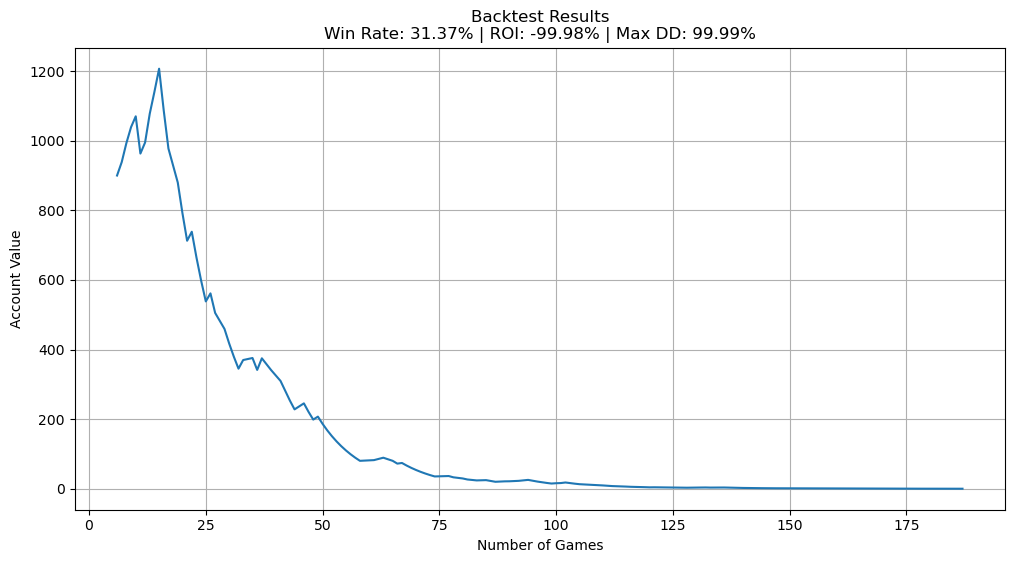

{'final_value': 0.1549313585921605,
 'roi': -0.9998450686414078,
 'win_rate': 0.3137254901960784,
 'max_drawdown': 0.9998716242515225,
 'total_bets': 153}

In [18]:
nfl_utils.backtest_model(model, perf_conts, perf_y_col, perf_date_col, initial_capital=1000, position_size=0.1, 
                   confidence_threshold=0.0, show_plot=True, max_won_odds=2.2)

Value:  0.37491718013436764

Params: 
    first_layer_size: 8
    num_layers: 2
    n_epochs: 39
    dropout: 0.47875406200808335
    lr: 0.009997751942238913
    


Value:  0.3759073484440955
Params: 
    first_layer_size: 8
    num_layers: 2
    n_epochs: 68
    dropout: 0.4497689844977892
    lr: 0.007977206154472633
    
    
    
12/6

Trial 206 finished with value: 0.547218605316966 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.05966702820817666, 'n_epochs': 379, 'dropout': 0.36961850006275193, 'lr': 0.008649806179332952}. Best is trial 206 with value: 0.547218605316966.

[I 2024-12-06 12:49:28,047] Trial 579 finished with value: 0.5335308702482566 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.059979796814548306, 'n_epochs': 481, 'dropout': 0.2511747953677191, 'lr': 0.007942836869449217}. Best is trial 579 with value: 0.5335308702482566.


[I 2024-12-06 14:53:00,850] Trial 385 finished with value: 0.5547767877242975 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.003263372268063613, 'n_epochs': 300, 'dropout': 0.3153661030384182, 'lr': 0.00593138298730814}. Best is trial 385 with value: 0.5547767877242975.

[I 2024-12-06 15:32:38,969] Trial 583 finished with value: 0.550872165273167 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.010458110701511005, 'n_epochs': 336, 'dropout': 0.3188974735143638, 'lr': 0.006976522077116529}. Best is trial 385 with value: 0.5547767877242975.

[I 2024-12-06 15:55:26,133] Trial 669 finished with value: 0.5645423555160363 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0243907527056759, 'n_epochs': 370, 'dropout': 0.32998724447261185, 'lr': 0.0075018456671685696}. Best is trial 669 with value: 0.5645423555160363.

[I 2024-12-06 20:33:46,555] Trial 1737 finished with value: 0.5716002919237433 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.015368961704784596, 'n_epochs': 328, 'dropout': 0.348927921024466, 'lr': 0.009575624984802092}. Best is trial 1737 with value: 0.5716002919237433.


[I 2024-12-06 21:17:06,545] Trial 1889 finished with value: 0.5739803740995499 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.014029751567812504, 'n_epochs': 357, 'dropout': 0.34275064196127053, 'lr': 0.008692336113071646}. Best is trial 1889 with value: 0.5739803740995499.

[I 2024-12-10 09:39:54,796] Trial 1612 finished with value: 0.5748324966932515 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003855147984840053, 'dropout': 0.3182765851196762, 'lr': 0.008210651343970551, 'n_epochs': 219}. Best is trial 1612 with value: 0.5748324966932515.



Trial 1749 finished with value: 0.5772962775717783 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.8653941637231173e-05, 'dropout': 0.3181431308672629, 'lr': 0.009969598746996452, 'n_epochs': 231}.




['2024-02-11' 'SFO' 'KAN']
2024-02-11: w_odds:2.89 acct_val: 1000.00 usable cash: 900.00 won: False
['2024-10-10' 'SFO' 'SEA']
2024-10-10: w_odds:2.03 acct_val: 900.00 usable cash: 810.00 won: False
['2024-10-13' 'JAX' 'CHI']
2024-10-13: w_odds:1.46 acct_val: 810.00 usable cash: 729.00 won: False
['2024-10-14' 'BUF' 'NYJ']
2024-10-14: w_odds:1.99 acct_val: 729.00 usable cash: 656.10 won: False
2024-10-14: w_odds:1.36 acct_val: 656.10 usable cash: 590.49 won: False
2024-10-14: w_odds:1.43 acct_val: 590.49 usable cash: 531.44 won: True
2024-10-14: w_odds:1.58 acct_val: 615.80 usable cash: 469.86 won: True
2024-10-14: w_odds:1.46 acct_val: 651.67 usable cash: 404.69 won: False
2024-10-14: w_odds:1.30 acct_val: 586.50 usable cash: 346.04 won: True
2024-10-14: w_odds:1.25 acct_val: 604.00 usable cash: 285.64 won: False
2024-10-14: w_odds:1.33 acct_val: 543.60 usable cash: 231.29 won: True
['2024-10-17' 'DEN' 'NOR']
2024-10-17: w_odds:1.83 acct_val: 561.51 usable cash: 505.36 won: False
['20

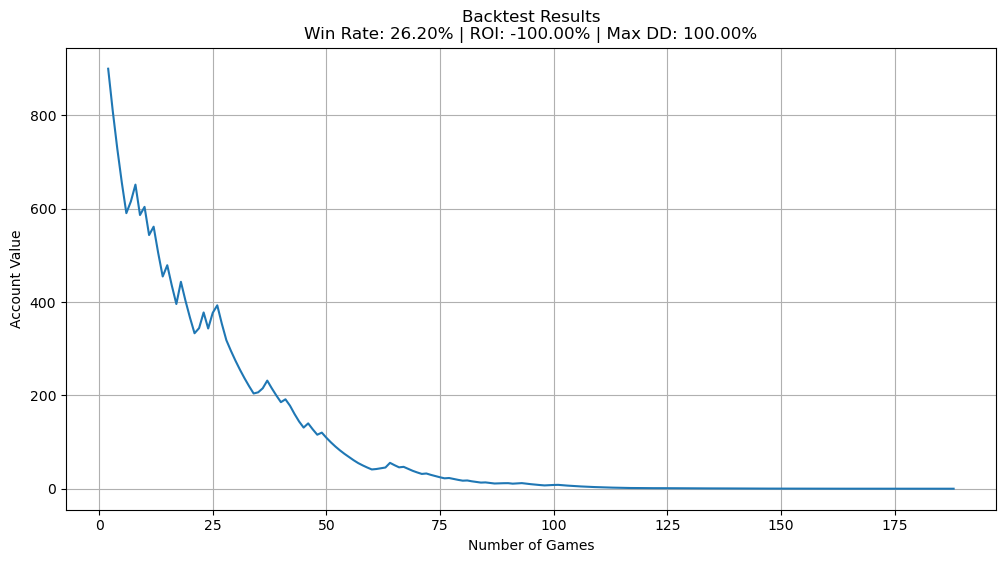

{'final_value': 0.015363152411150683,
 'roi': -0.9999846368475889,
 'win_rate': 0.2620320855614973,
 'max_drawdown': 0.9999846368475889,
 'total_bets': 187}

In [18]:
nfl_utils.backtest_model(pipeline, perf_conts, perf_y_col, perf_date_col, initial_capital=1000, position_size=0.05, confidence_threshold=best_params['confidence_threshold'], show_plot=True)


In [19]:
# Remove outside of confidence threshold
mask = (probas < 0.5 - confidence_threshold) | (probas > 0.5 + confidence_threshold)
predictions = np.where(mask, probas, np.nan)

# Use numpy mask for nan values
valid_mask = ~np.isnan(predictions)
valid_predictions = predictions[valid_mask]
valid_mask = valid_mask.flatten()
perf_y_col_mask = perf_y_col[valid_mask]


true_values = perf_y_col_mask[:,0].astype(np.int32)
pred_values = valid_predictions.flatten()
pred_values_int = np.rint(valid_predictions).flatten().astype(np.int32)

model_win_prob = (1.0*(true_values == pred_values_int).sum()) / (true_values.shape[0])
print(model_win_prob)

0.25654450261780104


# Using XGBoost

In [20]:
conts_train.shape

(5264, 49)

In [ ]:
# Fit the model
param_grid = {
    'learning_rate': [ 0.008, 0.01, 0.03],           # Removed 0.5, 1 as they're often too aggressive
    'max_depth': [3, 6, 9],                      # Simplified to 3 values, covering shallow to deep
    'n_estimators': [100, 200],                  # Removed extremes, these are most common sweet spots
    'subsample': [0.8, 1.0],                     # Removed 0.6 as it might be too aggressive for this dataset size
    'colsample_bytree': [0.8, 1.0],              # Same as above
    'min_child_weight': [1, 3],                  # Removed 5 as it might be too restrictive
}
aparam_grid = {
    'learning_rate': [0.005, 0.01, 0.05],        # Removed 0.5, 1 as they're often too aggressive
    'max_depth': [3],                         # Simplified to 3 values, covering shallow to deep
    'n_estimators': [300, 350, 400],             # Removed extremes, these are most common sweet spots
    'subsample': [0.5, 0.6, 0.7],                # Removed 0.6 as it might be too aggressive for this dataset size
    'colsample_bytree': [0.5, 0.6, 0.7],         # Same as above
    'min_child_weight': [3, 4],                  # Removed 5 as it might be too restrictive
}

# model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model = XGBRegressor(objective='reg:squarederror')

# Create a custom scorer using the F1 score
# f1_scorer = make_scorer(f1_score, average='weighted')
# Tune hyperparameters using GridSearchCV with the custom F1 scorer
# grid_search = GridSearchCV(model, param_grid, scoring=f1_scorer, cv=5, verbose=1)
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(conts_train, y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [ ]:
print(grid_search.best_params_)

In [ ]:

# train final model w/ early stopping
model = XGBClassifier(
    eval_metric='logloss',
    early_stopping_rounds=10,
    # **grid_search.best_params_,
    # **{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
    # 66.5%, dd 31.4%
    # {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
    # 66.5%, dd 30.9%
    # {'colsample_bytree': 1.0, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.6}
)
model = XGBRegressor(
    objective='reg:squarederror', 
    # **grid_search.best_params_,
    # 67.3 w/ kelly adjustments 0.2, 0.01
    # {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 350, 'subsample': 0.6}
    # 67.2, dd 28.68 kelly 0.25, 0.014
    # **{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 350, 'subsample': 0.5}
    
   # **{'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.5}
    **{'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


)
model.fit(
    conts_train,
    y_train,
    eval_set=[(conts_train, y_train)], # , (holdout_conts, holdout_y)
    verbose=True
)

In [ ]:
# perf_conts.shape
perf_y_col.shape
perf_y_col[0]

In [ ]:
# Make predictions for test data
# model = grid_search.best_estimator_
y_pred = model.predict(perf_conts)

nfl_utils.backtest_model(model, perf_conts, perf_y_col, perf_date_col, initial_capital=1000, position_size=0.1, 
                   confidence_threshold=0.0, show_plot=True, max_won_odds=2.2)

In [ ]:
# Make confusion matrix
cm = confusion_matrix(perf_y_col[:,0], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Save XGBoost model

In [ ]:
model.save_model('xgboost_model.bin')